In [1]:
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns



In [2]:
df = pd.read_csv("../data/01_raw/synthetic_dataset.csv")

print(df.head())

   transaction_id     transaction_time  transaction_amount  sender_id  \
0               0  2025-11-03 07:45:47             1421.63  acc599093   
1               1  2025-11-07 19:13:23             1473.02  acc211913   
2               2  2025-10-06 04:51:22               80.15  acc772503   
3               3  2025-10-28 16:03:19             1165.74  acc150241   
4               4  2025-11-09 17:41:20              538.76  acc672973   

                name             cpf receiver_id       receiver_name  \
0       Leo Ferreira  972.085.164-30   acc194554       Alice Machado   
1   Jose Pedro Silva  763.948.512-64   acc412294     Benicio da Mota   
2      Heitor Farias  187.049.532-23   acc895327  Maria Isis Machado   
3  Julia Casa Grande  624.819.073-96   acc914526  Ana Carolina Lopes   
4      Maite da Mota  890.536.427-65   acc433633     Daniel Oliveira   

  transaction_type     transaction_city  ... device_id device_model  \
0              pix     Sampaio Paulista  ...      dv65   

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114776 entries, 0 to 114775
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      114776 non-null  int64  
 1   transaction_time    114776 non-null  object 
 2   transaction_amount  114776 non-null  float64
 3   sender_id           114776 non-null  object 
 4   name                114776 non-null  object 
 5   cpf                 114776 non-null  object 
 6   receiver_id         114776 non-null  object 
 7   receiver_name       114776 non-null  object 
 8   transaction_type    114776 non-null  object 
 9   transaction_city    114776 non-null  object 
 10  birth_date          114776 non-null  object 
 11  address_pcode       114776 non-null  object 
 12  phone_number        114776 non-null  object 
 13  acc_creation_date   114776 non-null  object 
 14  agency              114776 non-null  int64  
 15  account             114776 non-nul

In [4]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

df['birth_date'] = pd.to_datetime(df['birth_date'])

df['acc_creation_date'] = pd.to_datetime(df['acc_creation_date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114776 entries, 0 to 114775
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   transaction_id      114776 non-null  int64         
 1   transaction_time    114776 non-null  datetime64[ns]
 2   transaction_amount  114776 non-null  float64       
 3   sender_id           114776 non-null  object        
 4   name                114776 non-null  object        
 5   cpf                 114776 non-null  object        
 6   receiver_id         114776 non-null  object        
 7   receiver_name       114776 non-null  object        
 8   transaction_type    114776 non-null  object        
 9   transaction_city    114776 non-null  object        
 10  birth_date          114776 non-null  datetime64[ns]
 11  address_pcode       114776 non-null  object        
 12  phone_number        114776 non-null  object        
 13  acc_creation_date   114776 no

In [5]:
df['sender_age'] = ((df['transaction_time'] - df['birth_date']).dt.days/365).astype(int)

df['transaction_hour'] = df['transaction_time'].dt.hour

df['large_amt'] = df['transaction_amount'] > 10000

df['acc_age_days'] = (df['transaction_time'] - df['acc_creation_date']).dt.days

print(df.head())

   transaction_id    transaction_time  transaction_amount  sender_id  \
0               0 2025-11-03 07:45:47             1421.63  acc599093   
1               1 2025-11-07 19:13:23             1473.02  acc211913   
2               2 2025-10-06 04:51:22               80.15  acc772503   
3               3 2025-10-28 16:03:19             1165.74  acc150241   
4               4 2025-11-09 17:41:20              538.76  acc672973   

                name             cpf receiver_id       receiver_name  \
0       Leo Ferreira  972.085.164-30   acc194554       Alice Machado   
1   Jose Pedro Silva  763.948.512-64   acc412294     Benicio da Mota   
2      Heitor Farias  187.049.532-23   acc895327  Maria Isis Machado   
3  Julia Casa Grande  624.819.073-96   acc914526  Ana Carolina Lopes   
4      Maite da Mota  890.536.427-65   acc433633     Daniel Oliveira   

  transaction_type     transaction_city  ... receiver_account gender  \
0              pix     Sampaio Paulista  ...           767552 

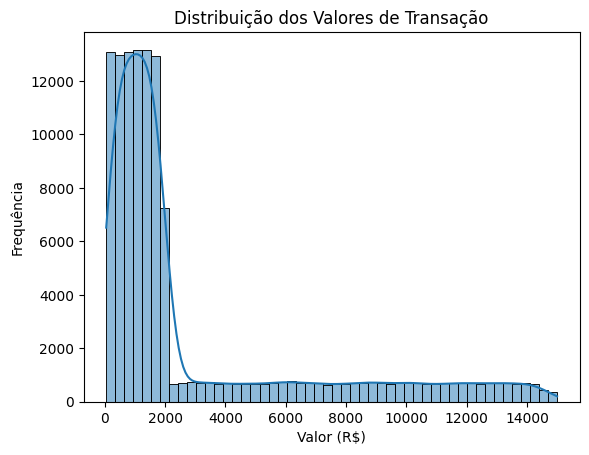

In [6]:
sns.histplot(df['transaction_amount'], bins=50, kde=True)
plt.title('Distribuição dos Valores de Transação')
plt.xlabel('Valor (R$)')
plt.ylabel('Frequência')
plt.show()

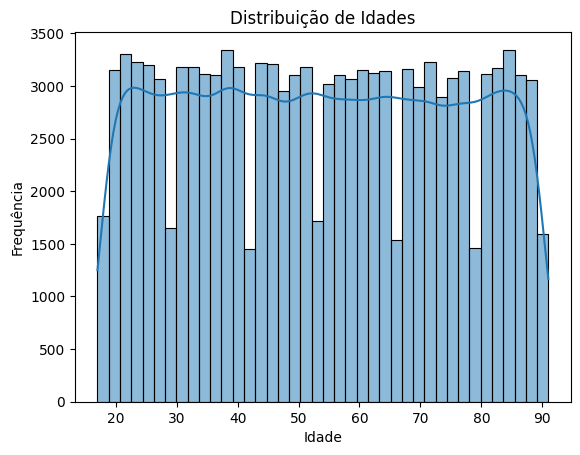

In [7]:
sns.histplot(df['sender_age'], bins=40, kde=True)
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.title('Distribuição de Idades')
plt.show()

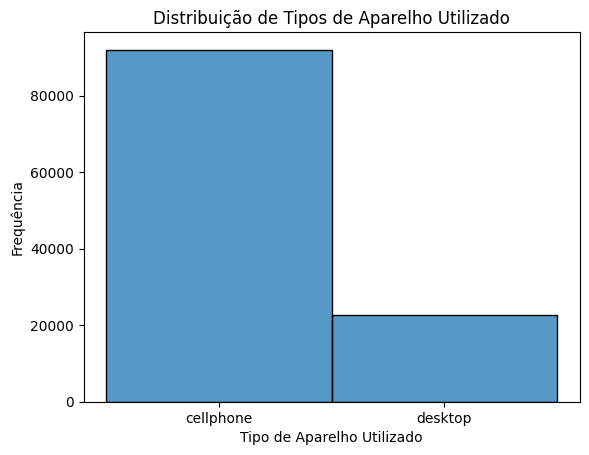

In [8]:
sns.histplot(df['device'], bins=3)
plt.xlabel('Tipo de Aparelho Utilizado')
plt.ylabel('Frequência')
plt.title('Distribuição de Tipos de Aparelho Utilizado')
plt.show()

Análise de grafos

In [10]:
G = nx.from_pandas_edgelist(
    df,
    source='sender_id',    # Origem da seta
    target='receiver_id',   # Ponta da seta
    edge_attr=['transaction_amount', 'acc_age_days'],    # Dados para 'pendurar' na aresta
    create_using=nx.MultiDiGraph()       # Permite multiplas arestas entre os nós
)

In [11]:
total_received = df.groupby('receiver_id')['transaction_amount'].sum()
total_sent = df.groupby('sender_id')['transaction_amount'].sum()

In [12]:
in_degree = dict(G.in_degree())
sus_id = [node for node, degree in in_degree.items() if degree > 10]
print(f"{len(sus_id)} contas recebem de muita gente")

904 contas recebem de muita gente


In [13]:
for conta_id in sus_id:
    in_degree = G.in_degree(conta_id)

    out_degree = G.out_degree(conta_id)

    if in_degree >=10 and out_degree > 0 and out_degree <= 3:
        print(f"Conta {conta_id} recebe de {in_degree} contas e envia para apenas {out_degree} contas")

Conta acc001403 recebe de 12 contas e envia para apenas 2 contas
Conta acc456666 recebe de 11 contas e envia para apenas 3 contas
Conta acc690776 recebe de 12 contas e envia para apenas 1 contas


In [14]:
metrics_list = []

for sus in sus_id:
    amt_in = total_received.get(sus, 0)
    amt_out = total_sent.get(sus, 0)

    if amt_in > 0:
        ratio = amt_out / amt_in

    else:
        ratio = 0

    if 0.8 <= ratio <= 1.05:
        metrics_list.append({
            'account_id': sus,
            'total_in': amt_in,
            'total_out': amt_out,
            'ratio': ratio,
            'type': 'Suspeita de Laranja'
        })
    elif ratio > 1.05:
        pass

suspects_df = pd.DataFrame(metrics_list)

if not suspects_df.empty:
    print(suspects_df.sort_values('ratio', ascending=False).head(10))

    account_id   total_in  total_out     ratio                 type
393  acc461828   11070.87   11551.57  1.043420  Suspeita de Laranja
490  acc360404  105114.54  102103.11  0.971351  Suspeita de Laranja
212  acc369765   86412.18   83928.84  0.971262  Suspeita de Laranja
13   acc683592   94064.56   91327.68  0.970904  Suspeita de Laranja
1    acc505314  114418.51  111015.19  0.970256  Suspeita de Laranja
56   acc984677  103321.12  100241.70  0.970196  Suspeita de Laranja
549  acc489905  104134.64  101030.97  0.970196  Suspeita de Laranja
340  acc010089   83471.02   80978.13  0.970135  Suspeita de Laranja
474  acc950835   73187.33   70999.77  0.970110  Suspeita de Laranja
34   acc848166  111960.60  108611.46  0.970086  Suspeita de Laranja


In [15]:
# Agrupando por conta para saber a 'velocidade' média do dinheiro
avg_in_time = df.groupby('receiver_id')['transaction_time'].mean()
avg_out_time = df.groupby('sender_id')['transaction_time'].mean()

# DataFrame auxiliar
time_features = pd.DataFrame(index=df['sender_id'].unique())
time_features.index.name = 'account_id'

# Calculando a diferença em HORAS
# avg_retention_hours negativo = enviou antes de receber (dinheiro parado/antigo)
# avg_retention_hours positivo e pequeno = o dinheiro 'queima' na mão.
time_features['avg_retention_hours'] = (avg_out_time - avg_in_time).dt.total_seconds() / 3600

# Preencher NaN quem só recebeu ou só enviou com um valor alto
time_features['avg_retention_hours'] = time_features['avg_retention_hours'].fillna(9999)

print(time_features.head())

            avg_retention_hours
account_id                     
acc599093           -552.812389
acc211913           -290.878472
acc772503            145.180389
acc150241           -358.697034
acc672973            317.030556


In [16]:
# Criar DataFrame base com todos os nós

# Métricas de Grafos
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# Métricas Financeiras
total_in = df.groupby('receiver_id')['transaction_amount'].sum()
total_out = df.groupby('sender_id')['transaction_amount'].sum()

# Montar o DataFrame Mestre com todos os nós
all_nodes = list(G.nodes())
metrics_df = pd.DataFrame(index=all_nodes)
metrics_df.index.name = 'account_id'

metrics_df['in_degree'] = metrics_df.index.map(in_degree).fillna(0)
metrics_df['out_degree'] = metrics_df.index.map(out_degree).fillna(0)
metrics_df['total_in'] = total_in
metrics_df['total_out'] = total_out

metrics_df = metrics_df.join(time_features['avg_retention_hours'])

# Calcular Ratio
metrics_df['ratio'] = metrics_df['total_out'] / (metrics_df['total_in'] + 0.01)

# Preencher vazios
metrics_df = metrics_df.fillna(0)

print(f"Dataset pronto para ML com {len(metrics_df)} contas.")

Dataset pronto para ML com 29940 contas.


In [17]:
# Definindo suspeitos
metrics_df['is_suspect'] = 0

suspect = (
    (metrics_df['in_degree'] > 5) &                   # Recebe de vários
    (metrics_df['ratio'].between(0.8, 1.05)) &        # Repassa quase tudo
    (metrics_df['avg_retention_hours'] < 12) &        # Repassa muito rápido (12h)
    (metrics_df['total_in'] > 10000)                  # Valores altos
)

metrics_df.loc[suspect, 'is_suspect'] = 1

print(metrics_df['is_suspect'].value_counts())

is_suspect
0    28554
1     1386
Name: count, dtype: int64


In [18]:
print(metrics_df.head())

            in_degree  out_degree  total_in  total_out  avg_retention_hours  \
account_id                                                                    
acc599093           1          10    912.39   22153.15          -552.812389   
acc194554           4           2   5239.40     874.01          -343.818819   
acc211913           4           4   2255.21    4749.44          -290.878472   
acc412294           4           3   3902.02    4275.08            -6.705185   
acc772503           1           5   1071.86   22877.51           145.180389   

                ratio  is_suspect  
account_id                         
acc599093   24.280085           0  
acc194554    0.166815           0  
acc211913    2.105976           0  
acc412294    1.095604           0  
acc772503   21.343549           0  


In [19]:
# Converte para um arquivo compacto que será usado na modelagem

metrics_df.to_parquet('../data/01_raw/metrics_df.parquet')